In [1]:
import math, random

# import gym
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
from collections import deque

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

modified from https://github.com/higgsfield/RL-Adventure/blob/master/1.dqn.ipynb

# Use CUDA

In [2]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

# Create Replay Buffer Class

In [3]:


class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

# $\epsilon$ - greedy exploration schedule

In [4]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

#exponential decay of randomness in behavior
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

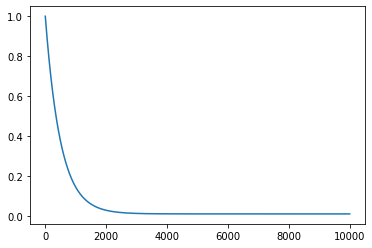

In [5]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

# Test first on OpenAI Gym's Cart Pole for debugging

In [6]:
env_id = "CartPole-v0"
env = gym.make(env_id)

# Deep Q Network
non-convolutional implementation

In [7]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        self.num_inputs = num_inputs
        self.num_actions = num_actions
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 128), # change to match task encoding
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions) # change to match task encoding
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(state).unsqueeze(0))
            q_value = self.forward(state)
#             print(q_value.max(1)[1])
            action  = torch.argmax(torch.squeeze(q_value)).item() #q_value.max(1)[1].item()
        else:
            action = random.randrange(self.num_actions)
        return action

In [8]:
print(env.observation_space.shape[0], env.action_space.n)
model = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

4 2


# TD-Loss

In [9]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    with torch.no_grad():
        next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [10]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

# Training

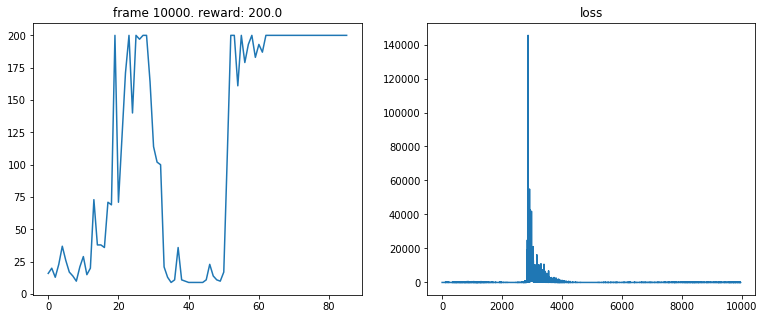

In [11]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
#     print(action)
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)

# One-hot encoding version of pinball reach task

In [12]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        self.num_inputs = num_inputs
        self.num_actions = num_actions
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 256), # change to match task encoding
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128, num_actions) # change to match task encoding
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(state).unsqueeze(0))
            q_value = self.forward(state)
#             print(q_value.max(1)[1])
            action  = torch.argmax(torch.squeeze(q_value)).item() #q_value.max(1)[1].item()
        else:
            action = random.randrange(self.num_actions)
        return action

In [22]:
class parametric_hand_target:
    def __init__(self,king_moves=True):
        self.hand_set = False
        self.target_set = False
        self.xlim = [-10,10]
        self.ylim = [-10,10]
        self.observation_shape = [1,4]
        self.reward_radius = 1
        
        
        # encode hand state as one hot matrix - leave empty 
        self.hand = None #np.zeros((npixelsx,npixelsy))
        
        # encode target state - leave empty until target is placed
        self.target = None #np.zeros((npixelsx,npixelsy))
        
        
        if king_moves:
            self.num_actions = 9
            self.actions = np.array([[0,0],
                           [1,0],
                           [0,1],
                           [-1,0],
                           [0,-1],
                           [1,1],
                           [1,-1],
                           [-1,1],
                           [-1,-1]])
        else:
            self.num_actions = 5
            self.actions = np.array([[0,0],
                           [1,0],
                           [0,1],
                           [-1,0],
                           [0,-1]])
            
    def place_hand(self,x,y):
        self.hand = np.array([x,y])
        self.hand_set=True
        
        
    def place_target(self,x,y):
        self.target = np.array([x,y])
        self.target_set = True
        
        
    def init_trial(self,hx,hy,tx,ty):
        # place hand
        self.place_hand(hx,hy)
        
        # place target
        self.place_target(tx,ty)
        
        # calculate screen
        return self.get_state(), -1, 0
        
    
    def get_state(self):
        return np.expand_dims(np.concatenate([self.hand,self.target]),0)
        
    def step(self,a):
#         assert a<self.num_actions-1 , "action index can't exceed number of available actions"
        action = self.actions[a,:]
        
        self.hand[0]= np.clip(self.hand[0]+action[0],*self.xlim)
        self.hand[1]= np.clip(self.hand[1]+action[1],*self.ylim)
        
        if (np.abs(self.hand[0]-self.target[0])<self.reward_radius) and (np.abs(self.hand[1]-self.target[1])<self.reward_radius):
            reward = 10000
            done=True
        else:
            reward = -np.abs(self.hand[0]-self.target[0]) - np.abs(self.hand[1]-self.target[1])
            done =False
        
        return self.get_state(), reward, done

In [28]:
epsilon_start = 1
epsilon_final = 0.1
epsilon_decay = 1000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

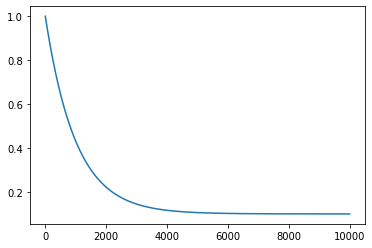

In [29]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

In [24]:
num_frames = 10000000
batch_size = 32
gamma      = 1.

losses = []
all_rewards = []
episode_reward = 0
ep = 0
h = parametric_hand_target()

model = DQN(4, h.num_actions)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

h.reward_radius = 1


state,_,reward = h.init_trial(*[np.random.randint(20)-10 for i in range(4)])
for frame_idx in range(1,num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    next_state, reward, done = h.step(action)
    if reward==0:
        print(reward)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        ep +=1
        if ep%100 == 0:
            h.reward_radius = np.maximum(h.reward_radius-1,1)
        
        state,_,_ = h.init_trial(*[np.random.randint(20)-10 for i in range(4)])
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > 1000:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 100 == 0:
        plot(frame_idx, all_rewards, losses)

KeyboardInterrupt: 

In [78]:
class one_hot_hand_target:
    def __init__(self,npixelx,npixely,king_moves=False):
        self.hand_set = False
        self.target_set = False
        self.npixelx = npixelx
        self.npixely = npixely
        self.observation_shape = [1,npixelx,npixely]
        
        
        # encode hand state as one hot matrix - leave empty 
        self.hand = None #np.zeros((npixelsx,npixelsy))
        
        # encode target state - leave empty until target is placed
        self.target = None #np.zeros((npixelsx,npixelsy))
        
        
        if king_moves:
            self.num_actions = 9
            self.actions = np.array([[0,0],
                           [1,0],
                           [0,1],
                           [-1,0],
                           [0,-1],
                           [1,1],
                           [1,-1],
                           [-1,1],
                           [-1,-1]])
        else:
            self.num_actions = 5
            self.actions = np.array([[0,0],
                           [1,0],
                           [0,1],
                           [-1,0],
                           [0,-1]])
            
    def place_hand(self,x,y):
        self.hand = np.array([x,y])
        self.hand_set=True
        
        
    def place_target(self,x,y):
        self.target = np.array([x,y])
        self.target_set = True
        
        
    def init_trial(self,hx,hy,tx,ty):
        # place hand
        self.place_hand(hx,hy)
        
        # place target
        self.place_target(tx,ty)
        
        # calculate screen
        return self.get_state(), -1, 0
        
        #return screen0
    def get_state(self):
        screen = np.zeros((self.npixelx,self.npixely))
        screen[self.hand[0],self.hand[1]]+=128
        screen[self.target[0],self.target[1]]+=256
        
        return np.expand_dims(screen,0)
    def step(self,a):
#         assert a<self.num_actions-1 , "action index can't exceed number of available actions"
        action = self.actions[a,:]
        
        self.hand[0]= np.minimum(np.maximum(self.hand[0]+action[0],0),self.npixelx-1)
        self.hand[1]= np.minimum(np.maximum(self.hand[1]+action[1],0),self.npixely-1)
        
        if (self.hand==self.target).all():
            reward = 0
            done=True
        else:
            reward = -1
            done =False
        
        return self.get_state(), reward, done

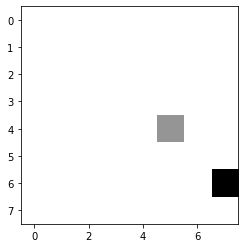

In [79]:
npix = 8
h = one_hot_hand_target(npix,npix)

state,_,_ = h.init_trial(np.random.randint(npix),np.random.randint(npix),np.random.randint(npix),np.random.randint(npix))

f,ax = plt.subplots()
ax.imshow(np.squeeze(state),cmap='Greys')


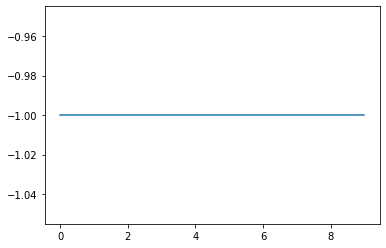

In [43]:
rewards = []
for i in range(10):
    state,reward,done = h.step(1)
#     f,ax = plt.subplots()
#     ax.imshow(np.squeeze(state),cmap='Greys')
    rewards.append(reward)
f,ax = plt.subplots()
ax.plot(rewards)


In [116]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=1, stride=1),
            nn.ReLU(),
#             nn.Conv2d(32, 32, kernel_size=1, stride=1),
#             nn.ReLU()
        )
#         print(self.features)
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 128),
            nn.ReLU(),
            nn.Dropout(p=.2),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0))
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(self.num_actions)
        return action

In [117]:

# print(h.observation_shape)
model = CnnDQN(h.observation_shape, h.num_actions)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters())

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

In [118]:
epsilon_start = 1
epsilon_final = 0.01
epsilon_decay = 10000

epsilon_by_episode = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

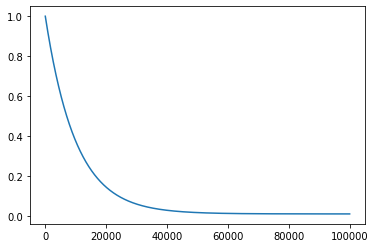

In [119]:
plt.plot([epsilon_by_frame(i) for i in range(100000)])

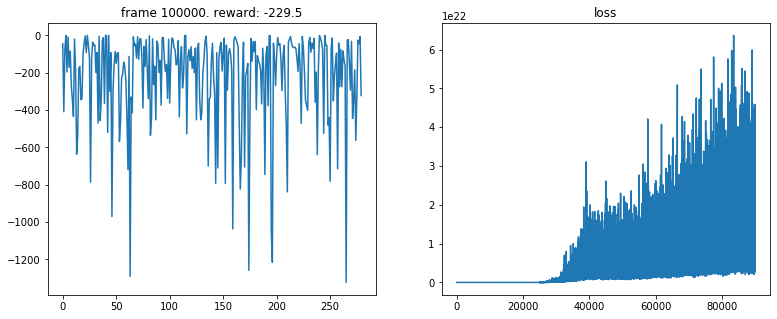

In [120]:
num_frames = 100000
batch_size = 32
gamma      = 1.

losses = []
all_rewards = []
episode_reward = 0
ep = 0
epframe = 0
h = one_hot_hand_target(npix,npix)
target_loc = [np.random.randint(npix),np.random.randint(npix)]
state,_,reward = h.init_trial(np.random.randint(npix),np.random.randint(npix),*target_loc)
for frame_idx in range(1,num_frames + 1):
    epsilon = epsilon_by_episode(epframe)
#     print(state.shape)
    action = model.act(state, epsilon)
#     print(action)
    next_state, reward, done = h.step(action)
    if reward==0:
        print(reward)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    epframe+=1
#     print(episode_reward)
    
    if done:
        ep +=1
        epframe=0
#         if ep%0:
        target_loc = [np.random.randint(npix),np.random.randint(npix)]
        
        state,_,_ = h.init_trial(np.random.randint(npix),np.random.randint(npix),*target_loc)
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 100 == 0:
        plot(frame_idx, all_rewards, losses)

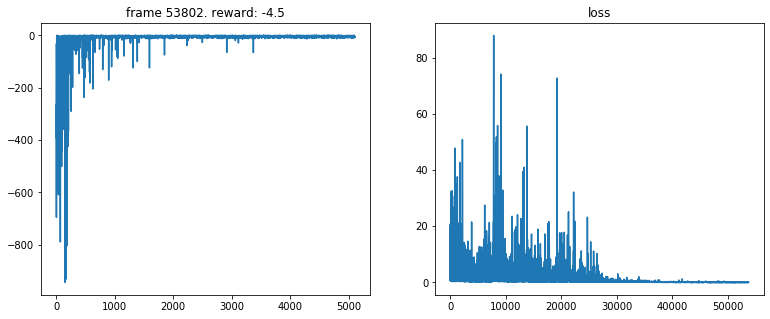

In [84]:
plot(frame_idx,all_rewards,losses)

In [121]:
16**2

256